# Trabajo práctico - Detección de esquinas - Harris

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy import signal


### Funciones generales de prácticas anteriores:

In [3]:
def cargar(nombre):
    img = Image.open(nombre).convert(mode='L')
    return np.array(img)


def mostrar(imagen, titulo=""):
    plt.figure(figsize=(9, 9))
    if (titulo): plt.title(titulo)
    plt.imshow(imagen, cmap='gray', vmin=0, vmax=255)


def pasarALog(imagen):
    c = 255 / np.log(1 + np.max(imagen))
    resultado = np.uint8(c * np.log(1 + imagen))
    return resultado


# valor entre 0 y 255
def aplicar_umbral(imagen, valor):
    return np.uint8(np.greater(imagen, valor) * 255)


# suavizado:
def suavizado_promedio(imagen, dimension):
    H = np.ones((dimension, dimension)) / dimension ** 2
    return signal.convolve2d(imagen, H, boundary="symm", mode="same")


def eqHist(imagen):
    hist = np.histogram(imagen, 256, range=(0, 256))
    acumulado = np.cumsum(hist[0])
    normalizado = 255 * ((acumulado - acumulado.min()) / (acumulado.max() - acumulado.min()))
    resultado = np.uint8(normalizado[imagen])
    return resultado


def ventana_gauss(dimension, desviacion):
    gauss1d = signal.windows.gaussian(dimension, desviacion)
    gauss2d = np.outer(gauss1d, gauss1d)
    return gauss2d / sum(sum(gauss2d))


def suavizado_gauss(imagen, std):
    gauss = ventana_gauss(int(4 * std), std)
    return signal.convolve2d(imagen, gauss, boundary="symm", mode="same")

### Algunas pruebas y carga de imágenes:

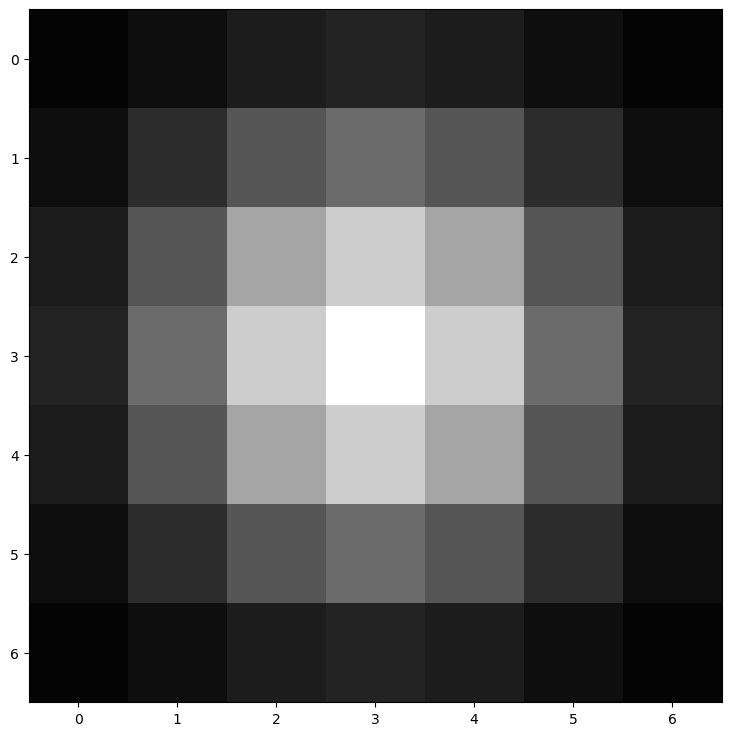

In [91]:
mostrar(pasarALog(ventana_gauss(7, 1.5)))

In [96]:
imagen_sin_ruido = cargar("esquinas_basecolor.png")
imagen_con_ruido = cargar("esquinas_basecolor_ruido.png")

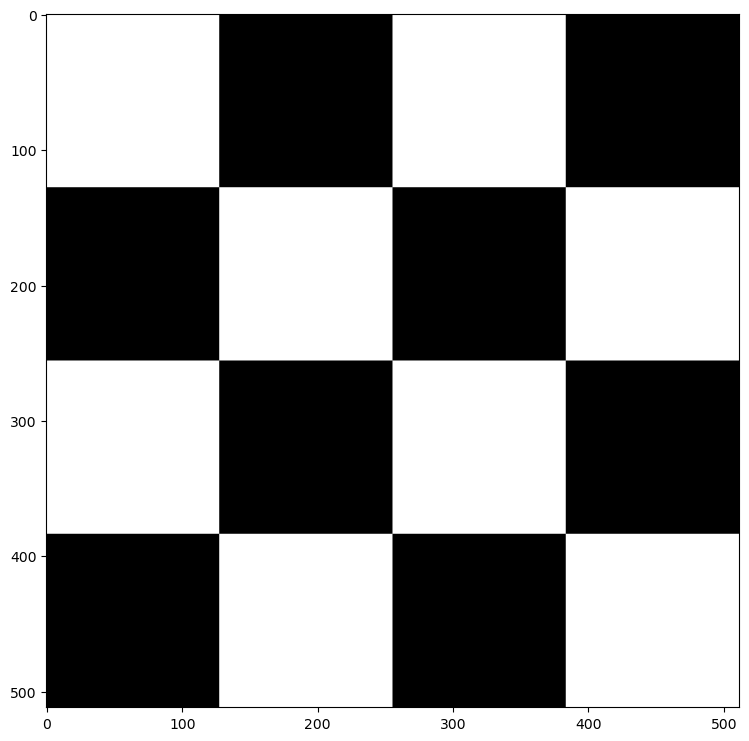

In [97]:
mostrar(imagen_sin_ruido)

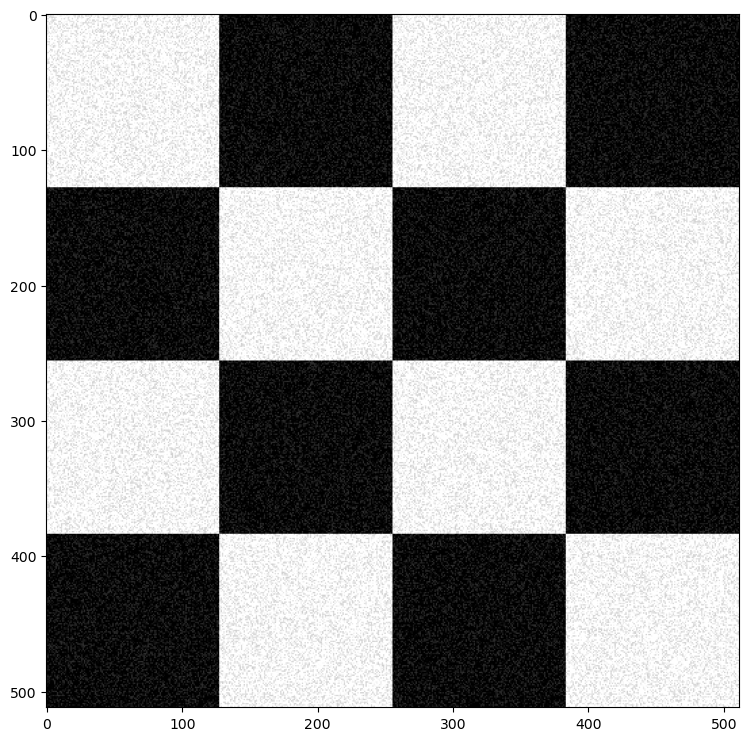

In [98]:
mostrar(imagen_con_ruido)

In [95]:
plt.matshow(imagen_con_ruido)

### Funciones auxiliares:

In [99]:
def calcula_derivadas(imagen):
    hx = np.array([[-1, 0, 1]])
    hy = hx.T
    Ix = signal.convolve2d(imagen, hx, mode="same")
    Iy = signal.convolve2d(imagen, hy, mode="same")

    return Ix, Iy

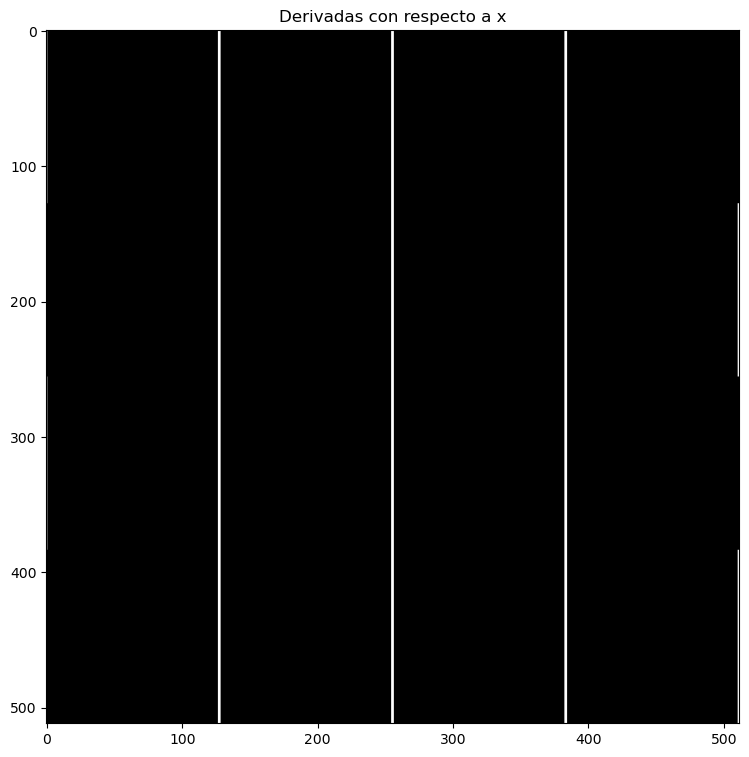

In [125]:
#prueba de derivadas:
Ix, Iy = calcula_derivadas(imagen_sin_ruido)
mostrar(np.abs(Ix), titulo="Derivadas con respecto a x")


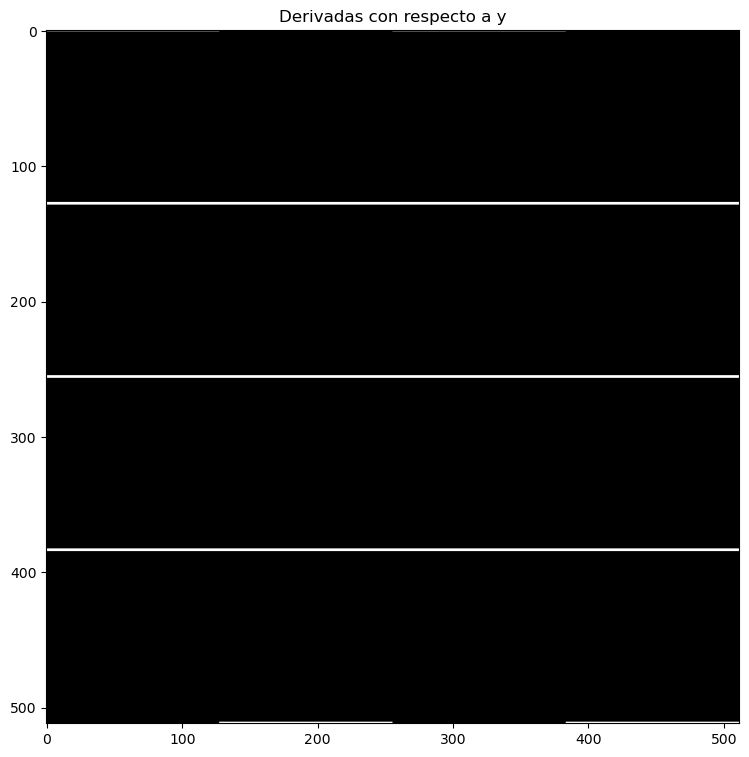

In [124]:
mostrar(np.abs(Iy), titulo="Derivadas con respecto a y")

### Implementación de Harris:

In [241]:
def harris(imagen, k=0.04, std=1, grafica=True, umbral=200):
    Ix, Iy = calcula_derivadas(imagen)

    Ix2 = np.square(Ix)
    Iy2 = np.square(Iy)
    IyIx = Ix * Iy

    h_gauss = ventana_gauss(int(5 * std), std)

    Ix2 = signal.convolve2d(Ix2, h_gauss, mode="same")
    Iy2 = signal.convolve2d(Iy2, h_gauss, mode="same")
    IyIx = signal.convolve2d(IyIx, h_gauss, mode="same")

    R = np.zeros(np.shape(imagen))
    alto = np.shape(imagen)[0]
    ancho = np.shape(imagen)[1]

    #calculo matriz R:
    for i in range(alto):
        for j in range(ancho):
            M = np.array([[Ix2[i, j], IyIx[i, i]],
                          [IyIx[i, j], Iy2[i, j]]])
            traza = np.matrix.trace(M)
            determinante = np.linalg.det(M)
            R[i, j] = determinante - k * (traza ** 2)

    R = np.abs(R)
    R_normalizado = R * 255 / np.max(R)

    if grafica:
        plt.figure(figsize=(9, 9))
        y, x = np.argwhere(R_normalizado > umbral).T

        plt.imshow(imagen, cmap='gray', vmin=0, vmax=255)
        plt.scatter(x, y, c='#51cc20', marker="X", s=200)

    return R_normalizado



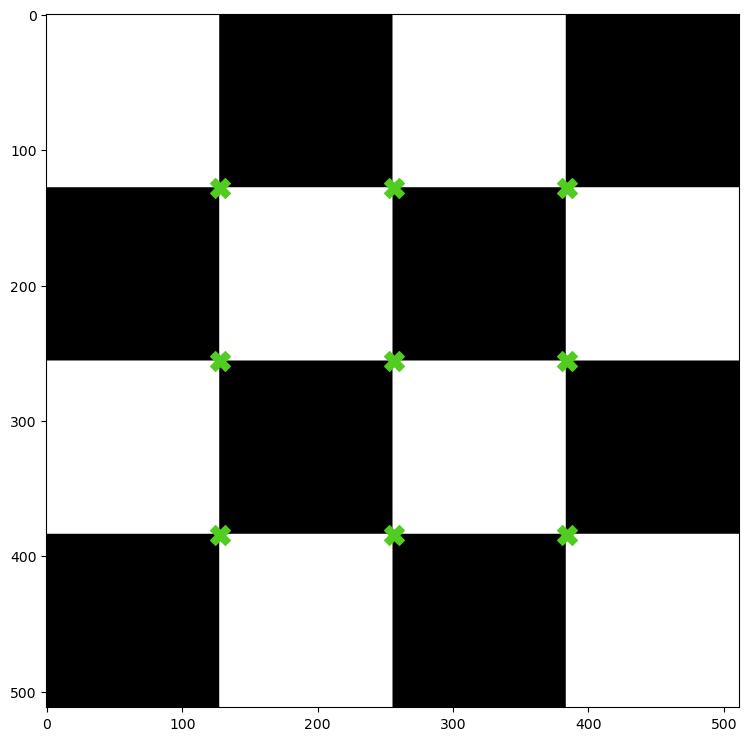

In [159]:
esquinas_1 = harris(imagen_sin_ruido, std=0.5)

In [169]:
np.argwhere(esquinas_1 > 200).T

array([[128, 128, 128, 256, 256, 256, 384, 384, 384],
       [128, 256, 384, 128, 256, 384, 128, 256, 384]])

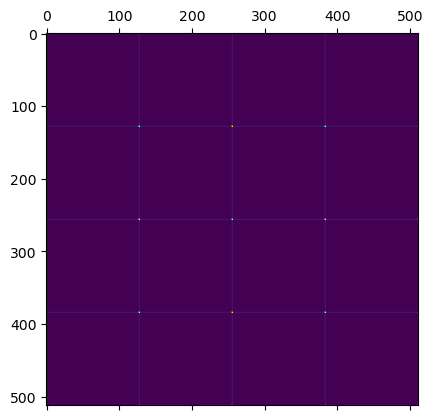

In [132]:
#visualización de matriz R:
plt.matshow(esquinas_1)

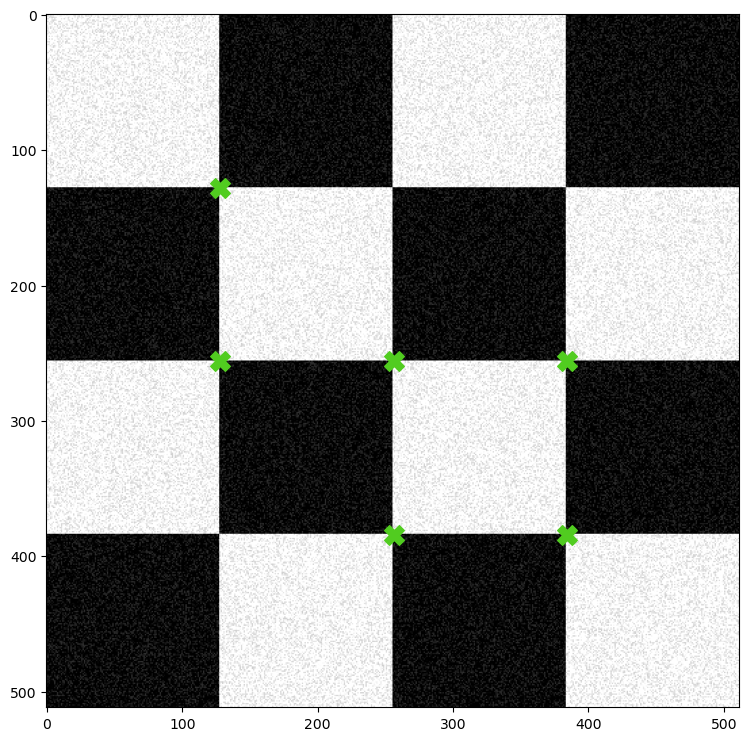

In [142]:
R_conruido = harris(imagen_con_ruido, std= 0.5)

La imagen con ruido produce una matriz R menos clara, y no detecta todas las esquinas con los mismo parámetros que la versión sin ruido:

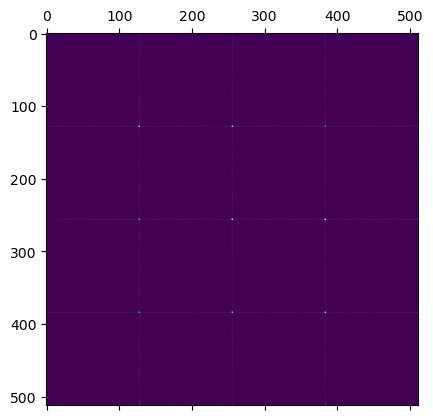

In [143]:
plt.matshow(R_conruido)

Si aumentamos la desviación standard de la ventana de Gauss mejora un poco (detecta 2 esquinas más):

array([[1.17001211e+01, 1.71728819e+01, 1.62266183e+01, ...,
        4.94797065e-03, 8.14795836e-03, 6.54905495e-03],
       [1.87374136e+01, 2.71099238e+01, 2.58487800e+01, ...,
        5.16835094e-02, 6.49469445e-02, 5.30038135e-02],
       [1.96270021e+01, 2.82021289e+01, 2.72179724e+01, ...,
        1.00040436e-01, 1.00964390e-01, 8.18486853e-02],
       ...,
       [1.18235097e-02, 3.44297264e-02, 6.18163527e-02, ...,
        1.50783171e+01, 2.14033405e+01, 2.18043351e+01],
       [2.04894607e-02, 4.01991829e-03, 2.99786772e-02, ...,
        2.10542706e+01, 3.07830526e+01, 3.20884383e+01],
       [5.49691161e-02, 5.18631776e-02, 2.11152318e-02, ...,
        2.07151194e+01, 3.09148206e+01, 3.25231389e+01]])

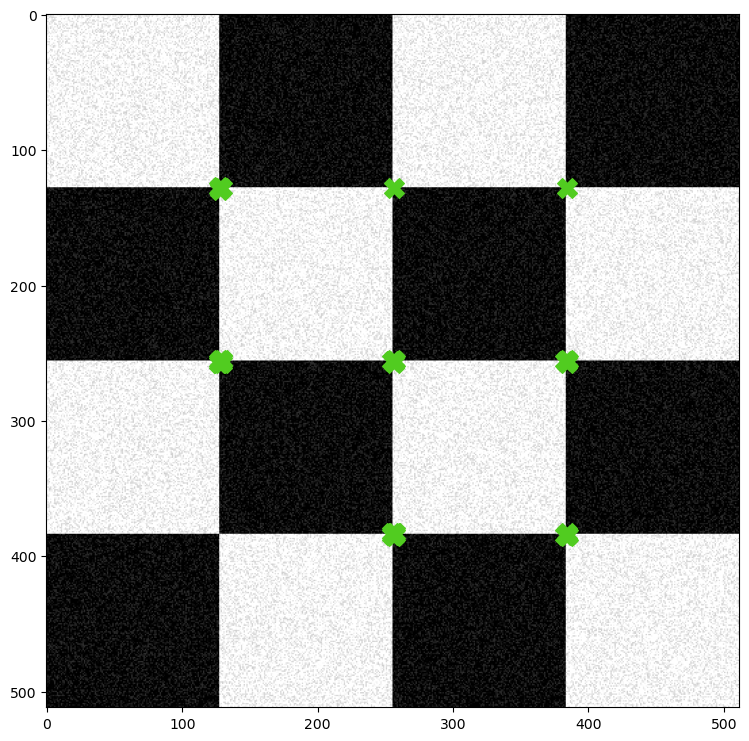

In [145]:
harris(imagen_con_ruido, std=2)

Si además bajamos el umbral detectamos todas las esquinas:

array([[1.17001211e+01, 1.71728819e+01, 1.62266183e+01, ...,
        4.94797065e-03, 8.14795836e-03, 6.54905495e-03],
       [1.87374136e+01, 2.71099238e+01, 2.58487800e+01, ...,
        5.16835094e-02, 6.49469445e-02, 5.30038135e-02],
       [1.96270021e+01, 2.82021289e+01, 2.72179724e+01, ...,
        1.00040436e-01, 1.00964390e-01, 8.18486853e-02],
       ...,
       [1.18235097e-02, 3.44297264e-02, 6.18163527e-02, ...,
        1.50783171e+01, 2.14033405e+01, 2.18043351e+01],
       [2.04894607e-02, 4.01991829e-03, 2.99786772e-02, ...,
        2.10542706e+01, 3.07830526e+01, 3.20884383e+01],
       [5.49691161e-02, 5.18631776e-02, 2.11152318e-02, ...,
        2.07151194e+01, 3.09148206e+01, 3.25231389e+01]])

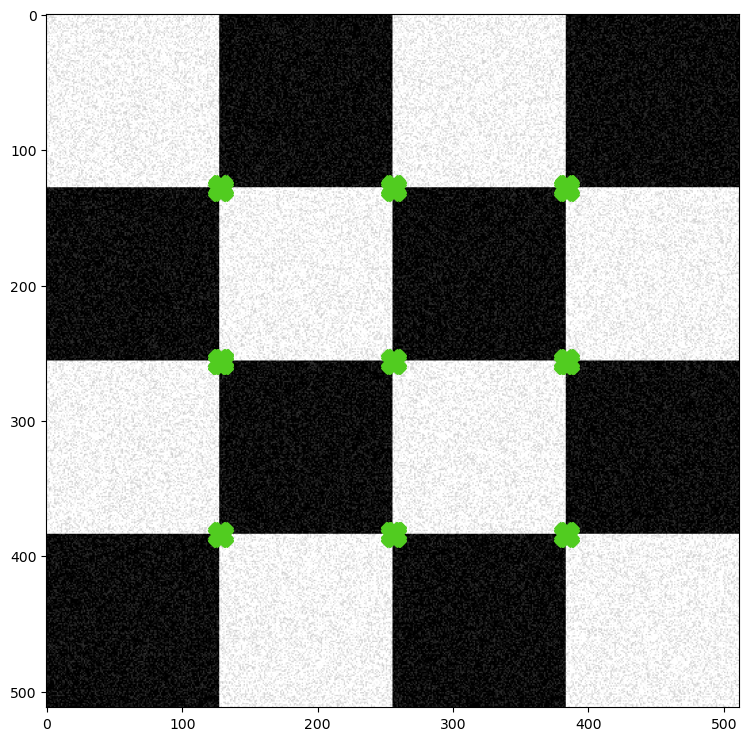

In [146]:
harris(imagen_con_ruido, std=2, umbral= 100)

Probamos que funciona también con una imagen rotada:

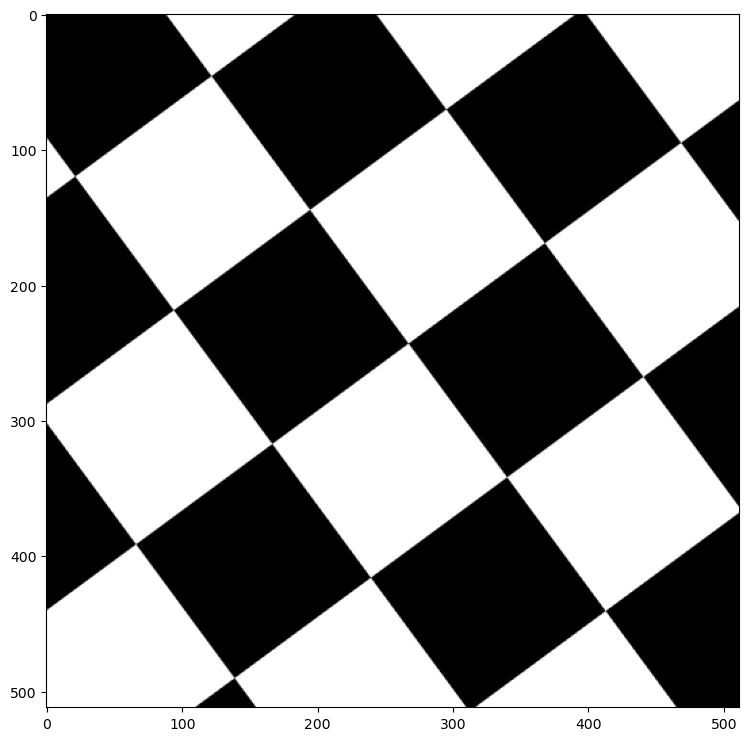

In [170]:
inclinado = cargar("inclinado_sin_ruido.png")
mostrar(inclinado)

array([[ 0.        ,  0.        ,  0.        , ...,  8.04948566,
         8.04948566, 32.19794263],
       [ 0.        ,  0.        ,  0.        , ...,  8.04948566,
         8.04948566, 68.42062808],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  8.04948566],
       ...,
       [ 8.04948566,  8.04948566,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 8.04948566,  8.04948566,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [32.19794263, 68.42062808,  8.04948566, ...,  0.        ,
         0.        ,  0.        ]])

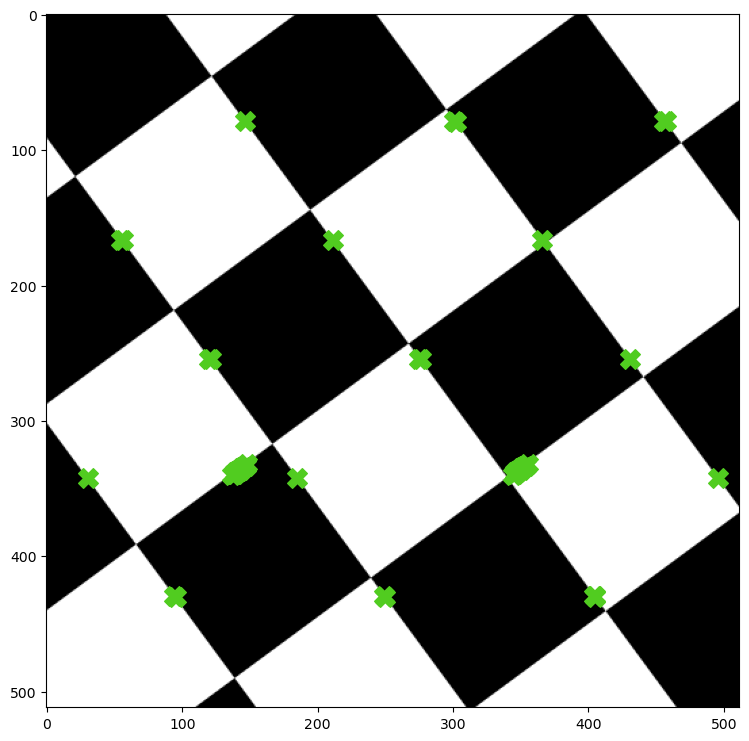

In [179]:
harris(inclinado, k=0.08, std=0.5, umbral= 150)

No obtengo buenos resultados, voy probando con otros parámteros:

array([[ 0.        ,  0.        ,  0.        , ..., 24.86454339,
        28.00154484, 26.44196132],
       [ 0.        ,  0.        ,  0.        , ..., 32.13624134,
        35.93927123, 33.76860563],
       [ 0.        ,  0.        ,  0.        , ..., 34.64604262,
        38.46723047, 35.93927123],
       ...,
       [24.86454339, 32.13624134, 34.64604262, ...,  0.        ,
         0.        ,  0.        ],
       [28.00154484, 35.93927123, 38.46723047, ...,  0.        ,
         0.        ,  0.        ],
       [26.44196132, 33.76860563, 35.93927123, ...,  0.        ,
         0.        ,  0.        ]])

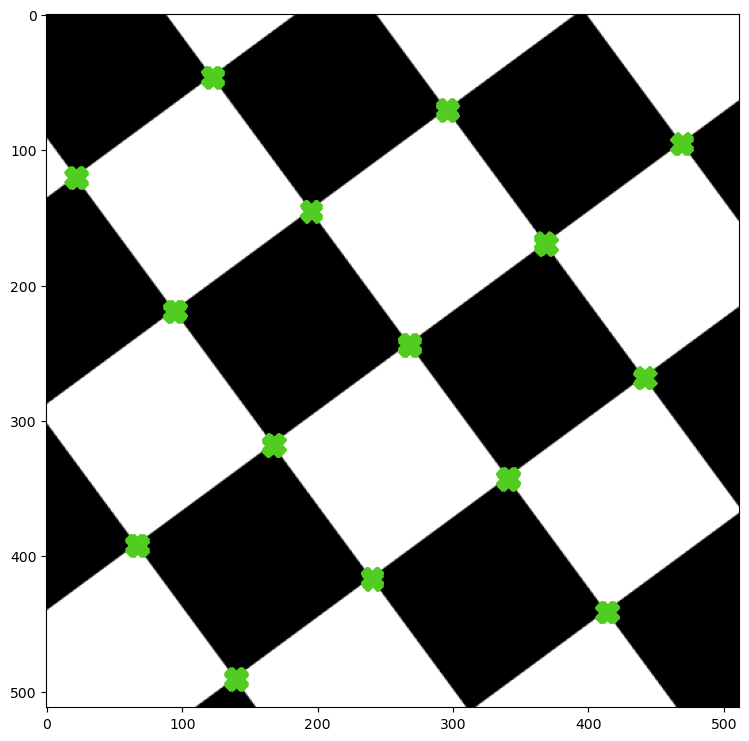

In [200]:
harris(inclinado, k=0.03, std=3, umbral= 220)

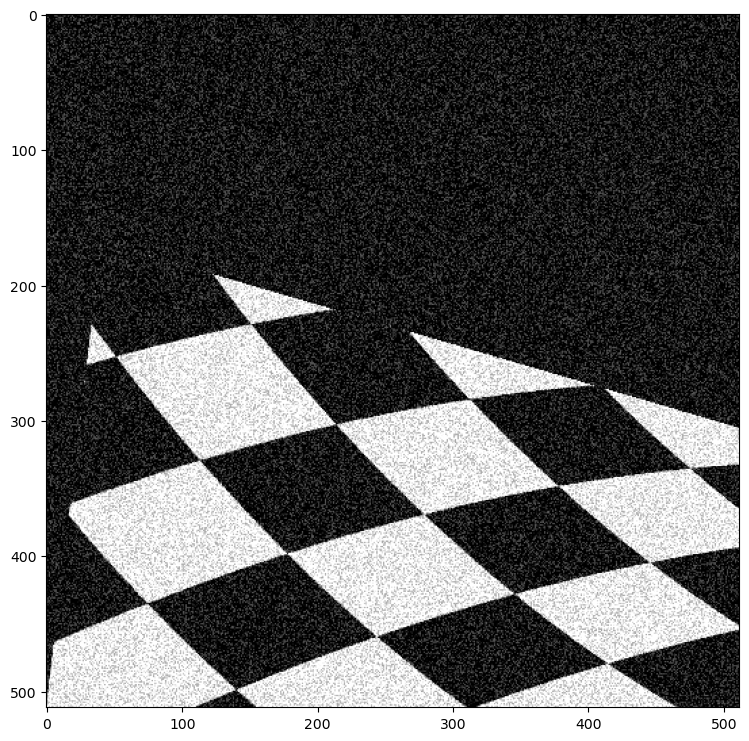

In [201]:
otra = cargar("otro.png")
mostrar(otra)

array([[ 0.47832406,  0.64608901,  0.85405358, ...,  1.63294055,
         1.31734455,  1.03498305],
       [ 0.60715064,  0.82019706,  1.07871848, ...,  2.08669153,
         1.67889885,  1.31602863],
       [ 0.74489222,  1.00457642,  1.31511326, ...,  2.5502546 ,
         2.0483131 ,  1.60070487],
       ...,
       [40.79057724, 47.44369925, 53.08054654, ...,  3.48135349,
         2.89900282,  2.34318223],
       [36.87130851, 42.90182289, 47.99777025, ...,  2.94256267,
         2.44977868,  1.98173772],
       [31.98896336, 37.23881397, 41.65242816, ...,  2.40019099,
         1.99716582,  1.61680579]])

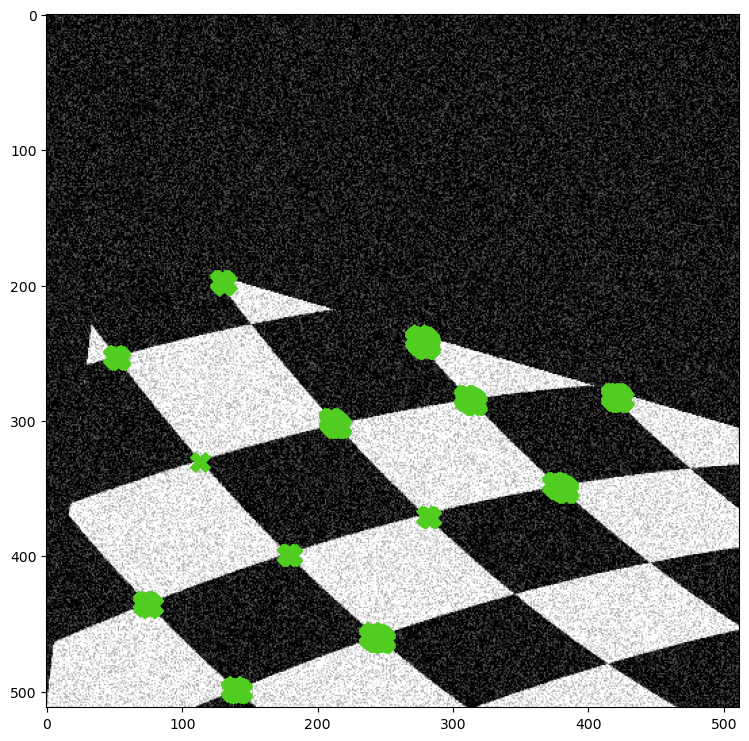

In [217]:
harris(otra, k=0.01, std=6, umbral= 195)

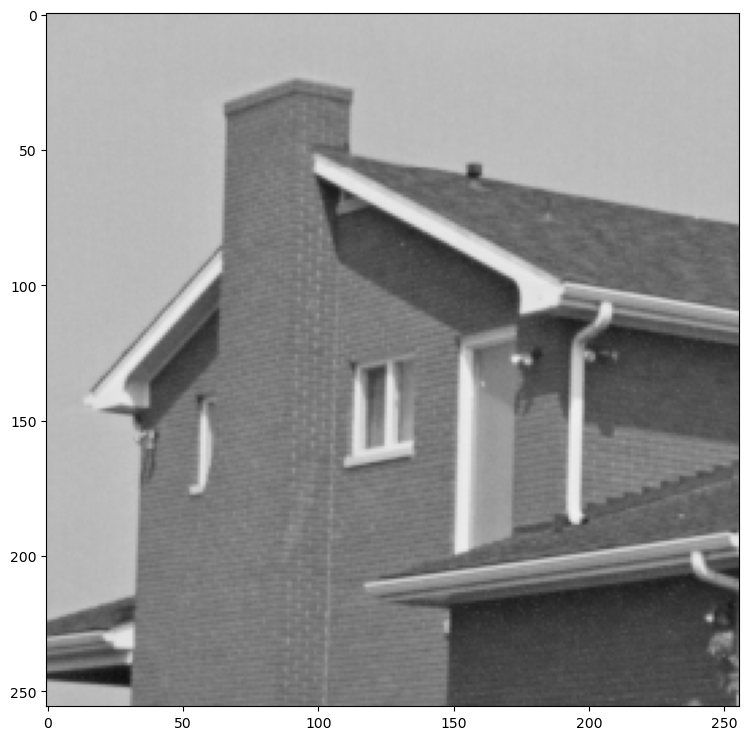

In [228]:
casa = cargar("house.png")
mostrar(casa)

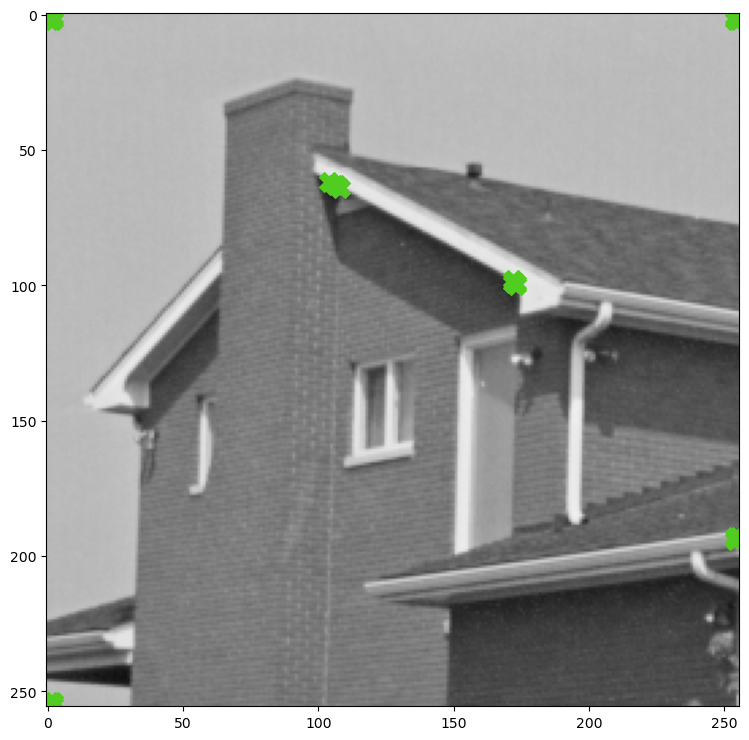

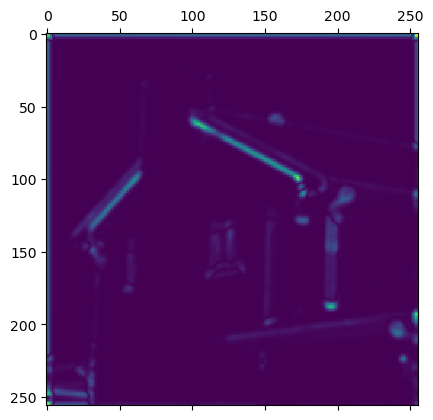

In [251]:
plt.matshow(harris(casa, k=0.1, std=2, umbral= 175))